In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np

from jaxlayerlumos import stackrt_eps_mu
from jaxlayerlumos import utils_materials

Let's Try to reproduce the result of Fig 6 in this paper:
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=238519

Design 1:
  Materials stack: ['Air', '14', '8', '4', '4', '4', 'PEC']
  Layer thicknesses (m): [0.       0.000966 0.001002 0.001182 0.000984 0.00138  0.      ]
Design 2:
  Materials stack: ['Air', '16', '4', '4', '4', '4', 'PEC']
  Layer thicknesses (m): [0.       0.000516 0.001092 0.00144  0.000306 0.000234 0.      ]
Design 3:
  Materials stack: ['Air', '14', '4', '4', '4', '4', 'PEC']
  Layer thicknesses (m): [0.       0.00018  0.000738 0.000918 0.000984 0.000114 0.      ]
Design 4:
  Materials stack: ['Air', '4', '4', '4', '4', '4', 'PEC']
  Layer thicknesses (m): [0.       0.000636 0.001284 0.000126 0.000156 0.000276 0.      ]


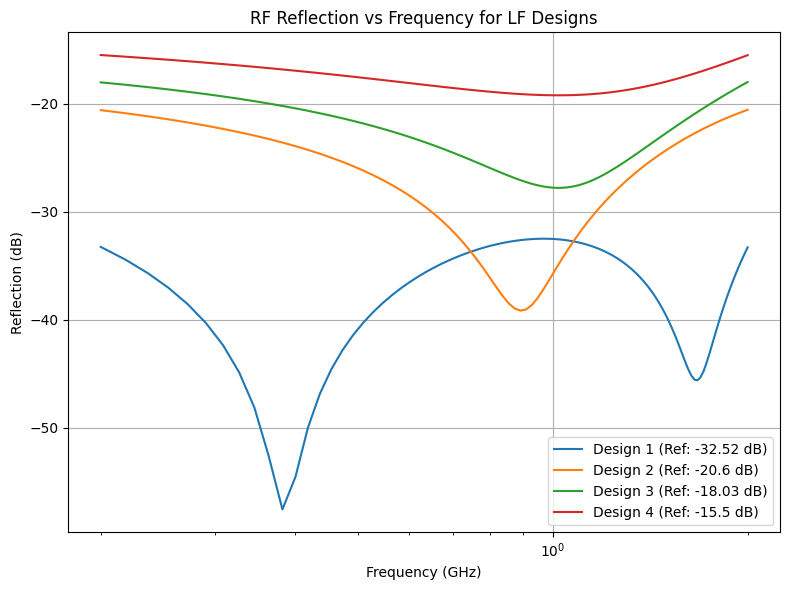

In [7]:
freq_range = (0.2, 2.0)  # GHz
inc_angle = 0.0          # degrees

# Frequency grid: from 0.2 GHz to 2.0 GHz (converted to Hz)
frequencies = jnp.linspace(freq_range[0] * 1e9, freq_range[1] * 1e9, 100)
freq_ghz = np.array(frequencies) / 1e9  # for plotting (in GHz)


designs = [
    {
        "materials_data": ["14", "8", "4", "4", "4"],
        "thicknesses_mm": [0.966, 1.002, 1.182, 0.984, 1.380],
        "ref_R_db": -32.52
    },
    {
        "materials_data": ["16", "4", "4", "4", "4"],
        "thicknesses_mm": [0.516, 1.092, 1.440, 0.306, 0.234],
        "ref_R_db": -20.60
    },
    {
        "materials_data": ["14", "4", "4", "4", "4"],
        "thicknesses_mm": [0.180, 0.738, 0.918, 0.984, 0.114],
        "ref_R_db": -18.03
    },
    {
        "materials_data": ["4", "4", "4", "4", "4"],
        "thicknesses_mm": [0.636, 1.284, 0.126, 0.156, 0.276],
        "ref_R_db": -15.50
    }
]

plt.figure(figsize=(8, 6))

# Loop over each design, compute the reflection, and plot the result.
for i, design in enumerate(designs, start=1):
    materials_data = design["materials_data"]
    thicknesses_mm = design["thicknesses_mm"]
    ref_R_db = design["ref_R_db"]

    # Augment the materials list with ambient "Air" and terminal "PEC"
    materials = ["Air"] + materials_data + ["PEC"]
    # Convert thicknesses from mm to m and pad with zeros for "Air" and "PEC"
    thicknesses = jnp.array([0.0] + [x * 1e-3 for x in thicknesses_mm] + [0.0])
    
    print(f"Design {i}:")
    print("  Materials stack:", materials)
    print("  Layer thicknesses (m):", thicknesses)

    # Compute the effective permittivity and permeability for the stack.
    eps_stack, mu_stack = utils_materials.get_eps_mu(materials, frequencies)
    # Compute reflection and transmission coefficients at normal incidence (0°).
    R_TE, T_TE, R_TM, T_TM = stackrt_eps_mu(eps_stack, mu_stack, thicknesses, frequencies, inc_angle)
    # Average the TE and TM reflections.
    R_linear = (R_TE + R_TM) / 2.0
    R_db = 10 * jnp.log10(R_linear).squeeze()  # Reflection in dB

    # Plot the reflection curve with a label indicating design number and reference value.
    plt.semilogx(freq_ghz, np.array(R_db), label=f"Design {i} (Ref: {ref_R_db} dB)")

# --- Plot formatting ---
plt.xlabel("Frequency (GHz)")
plt.ylabel("Reflection (dB)")
plt.title("RF Reflection vs Frequency for LF Designs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()